The empirical exercise should focus on how the sector and factor tilting works when a crisis comes, better diversification provided, consistent risk factor contributions, and greater resilience to economic shocks 

In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import cvxpy as cp
from tqdm.notebook import tqdm
from regimeaware.routines import cfg
from regimeaware.core import utils

rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)

# Data
rt_ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl')[cfg.factor_set]
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Reference market cap weights
mktcap = crsp['mktcap'].copy()
ref_wts = mktcap.groupby('permno').shift(1).reindex(factor_loadings.index.droplevel('factor').unique())
ref_wts = ref_wts.div(ref_wts.groupby('date').sum())

bm = ref_wts.groupby('id').shift(1).mul(crsp['excess_ret'].reindex(ref_wts.index)).groupby('date').sum().add(1).cumprod()

$$
\begin{equation}
\begin{aligned}
& \underset{w}{\text{argmin}} & & \gamma \left( w^{T} F^{T} \Sigma_{f} F w + w^{T} E w \right) - w^{T} \mu_{f} \\
& \text{s.t.} & & (w - b)^{T} \Sigma (w - b) \leq \bar{\sigma}^{2} \\
& & & \sum_{i=1}^{N} w_i = 1 \\
& & &  w_i \geq 0 \; ; \; \forall \; i =1, \ldots, N \\
\end{aligned}
\end{equation}
$$

In [2]:
collect_w = {}

for g in cfg.gamma_iter:
    for t in cfg.tev_budget_iter:
        for dt in tqdm(rebalance_dts, desc=f'gamma: {g}, te budget: {t * 100}%'):
            # Data handling
            sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
            mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
            mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
            Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
            F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
            E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
            b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
            b = np.divide(b, b.sum())

            # Optimization problem
            tev_budget = cp.Parameter(nonneg=True)
            gamma = cp.Parameter(nonneg=True)

            m, n = F.shape
            w = cp.Variable((n, 1))
            f = cp.Variable((m, 1))

            Sigma_f_const = np.zeros((m, m))
            Sigma_f_const[1:, 1:] = Sigma_f

            tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
            port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
            port_return = mu_f_const.T @ f

            constraints = [
                cp.sum(w) == 1,
                f == F @ w,
                w >= 0,
                tracking_error <= tev_budget 
            ]

            gamma.value = g
            tev_budget.value = (t / 12) ** 2 

            prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
            prob.solve(verbose=False)
            collect_w[(t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)


gamma: 0.5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 0.5, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

gamma: 1, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

gamma: 1, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

In [3]:
wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)

collect_bt = {}
for g in cfg.gamma_iter:
    for t in cfg.tev_budget_iter:
        wt = wts.xs(t).xs(g)
        collect_bt[(g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: {x}\nTE Budget: {y * 100}' for x,y in bt.columns]

<Axes: xlabel='date'>

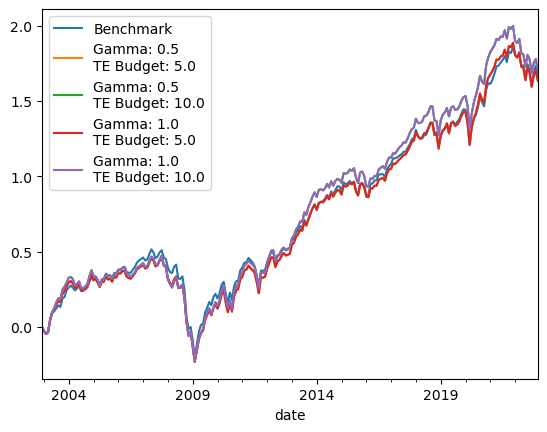

In [4]:
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

In [5]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()

Gamma: 1.0\nTE Budget: 5.0    -1.110290
Gamma: 0.5\nTE Budget: 5.0    -1.100144
Gamma: 0.5\nTE Budget: 10.0    2.067229
Gamma: 1.0\nTE Budget: 10.0    2.068883
dtype: float64

In [6]:
df.mean().div(df.std()).mul(np.sqrt(12)).sort_values()

Gamma: 0.5\nTE Budget: 10.0    5.382010
Gamma: 1.0\nTE Budget: 10.0    5.385195
Gamma: 0.5\nTE Budget: 5.0     5.735996
Gamma: 1.0\nTE Budget: 5.0     5.736673
Benchmark                      5.945814
dtype: float64

Obs
- Higher TEV-Budget leads to better IR
- Higher risk aversion leads to lower IR? 

In [7]:
"""
MVO is giving issues because the matrix is not invertible
When I do dropna gives me back two obervations, which should be wrong, as the tradabale securities have betas, and to have a beta we require 10 years of obervations (120 obs)
For this reason, I'd expect each stock to have the last 120 obs valid

Confirmed, the matrix is not invertible and that was causing the issues while optimizing

Two benchmarks:
1. EW
2. Historical beta estimation
"""

"\nMVO is giving issues because the matrix is not invertible\nWhen I do dropna gives me back two obervations, which should be wrong, as the tradabale securities have betas, and to have a beta we require 10 years of obervations (120 obs)\nFor this reason, I'd expect each stock to have the last 120 obs valid\n\nConfirmed, the matrix is not invertible and that was causing the issues while optimizing\n\nTwo benchmarks:\n1. EW\n2. Historical beta estimation\n"

In [8]:
collect_ew = {}

for dt in tqdm(rebalance_dts):
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    collect_ew[dt] = pd.Series(1 / len(sec_ids), index=sec_ids)


  0%|          | 0/241 [00:00<?, ?it/s]

In [9]:
wts = pd.DataFrame.from_dict(collect_ew, orient='index').fillna(0)
bt = wts.shift(1).mul(rt).dropna(how='all').sum(axis=1)


<Axes: xlabel='date'>

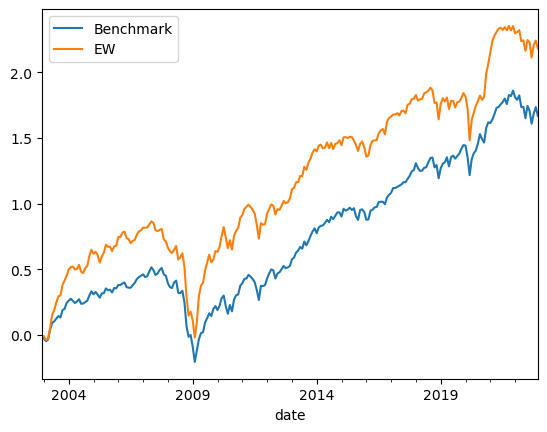

In [10]:
df = bm.to_frame(name='Benchmark').join(bt.rename('EW').add(1).cumprod())
df.apply(np.log).plot()

In [11]:
df.mean().div(df.std()).mul(np.sqrt(12)).sort_values()

EW           5.457701
Benchmark    5.945814
dtype: float64

In [12]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()

EW    4.620189
dtype: float64

In [13]:
collect_w = {}

for window in cfg.ols_windows:
    factor_loadings_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_betas_{window}.pkl')
    factor_variance_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_var_{window}.pkl')
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            for dt in tqdm(rebalance_dts, desc=f'window: {window}, gamma: {g}, te budget: {t * 100}%'):
                # Data handling
                sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
                
                factor_sample = rt_ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].iloc[-window:]
                mu_f = factor_sample.mean().values.reshape(-1, 1)
                mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
                Sigma_f = factor_sample.cov().values
                
                
                F = utils.unpack_betas(factor_loadings_ols.xs(dt)).reindex(sec_ids).values.T
                E = np.diag(factor_variance_ols.xs(dt).reindex(sec_ids))
                b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
                b = np.divide(b, b.sum())

                # Optimization problem
                tev_budget = cp.Parameter(nonneg=True)
                gamma = cp.Parameter(nonneg=True)

                m, n = F.shape
                w = cp.Variable((n, 1))
                f = cp.Variable((m, 1))

                Sigma_f_const = np.zeros((m, m))
                Sigma_f_const[1:, 1:] = Sigma_f

                tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
                port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
                port_return = mu_f_const.T @ f

                constraints = [
                    cp.sum(w) == 1,
                    f == F @ w,
                    w >= 0,
                    tracking_error <= tev_budget 
                ]

                gamma.value = g
                tev_budget.value = (t / 12) ** 2 

                prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
                prob.solve(verbose=False)
                collect_w[(window, t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)


window: 36, gamma: 0.5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


window: 36, gamma: 0.5, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

window: 36, gamma: 1, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 1, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

window: 60, gamma: 0.5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
factor_variance_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_var_{window}.pkl')
factor_variance_ols.xs(dt).sort_index()

In [ ]:
factor_variance_ols.xs(dt).xs(65533)

In [ ]:
wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)

collect_bt = {}
for w in cfg.ols_windows:
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            wt = wts.xs(w).xs(t).xs(g)
            collect_bt[(w, g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt_ols = pd.DataFrame.from_dict(collect_bt)
bt_ols = bt_ols.reindex(bm.index).fillna(0)
bt_ols.columns = [f'OLS-{w}M Gamma: {x}\nTE Budget: {y * 100}' for w, x, y in bt_ols.columns]

In [ ]:
df = bm.to_frame(name='Benchmark').join(bt_ols.add(1).cumprod())
df.apply(np.log).plot()

In [ ]:
df.mean().div(df.std()).mul(np.sqrt(12)).sort_values()

In [ ]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()